In [1]:
import os
import time
import random
import math

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from causal_bert import load_data, load_model
from causal_bert import true_casual_effect, est_casual_effect, show_result

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
effect = 'ate'
estimation = 'q'

effect = effect.lower()
estimation = estimation.lower()
assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [4]:
bsz = 16
epoch = 10
hidden_size = 64
lr = 5e-6

In [5]:
alpha = 0.5
beta = 5.
c = 0.2
i = 0.

train_loader, test_loader = load_data(alpha, beta, c, i, bsz, device=device)

Load training set in 99.22 sec
Load validation set in 84.80 sec


In [6]:
real_att_q = true_casual_effect(test_loader)

print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
print(f'Unadjusted: [value: {(test_loader.dataset.response[test_loader.dataset.treatment == 1].mean() - test_loader.dataset.response[test_loader.dataset.treatment == 0].mean()).item():.4f}]')

Real: [effect: ate], [estimation: q], [value: 0.11704]
Unadjusted: [value: 0.1880]


In [7]:
model = load_model(model='bert', hidden_size=hidden_size, device=device)

pos_portion = train_loader.dataset.treatment.mean()
pos_weight = (1 - pos_portion) / pos_portion

epoch_iter = len(train_loader)
total_steps = epoch * epoch_iter

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)

q_loss = nn.BCELoss()
prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [8]:
train_loss_hist_p, train_loss_hist_q1, train_loss_hist_q0 = [], [], []
test_loss_hist_p, test_loss_hist_q1, test_loss_hist_q0 = [], [], []
est_effect, prop_score_hist = [], []

for e in range(1, epoch + 1):
    model.train()
    start = time.time()
        
    p_loss_train, q1_loss_train, q0_loss_train  = [], [], []
    for idx, (tokens, treatment, response, _) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss_p = prop_score_loss(prop_score, treatment)
        loss = loss_p
        
        p_loss_train.append(loss_p.item())
        if len(response[treatment == 1]) > 0:
            loss_q1 = q_loss(q1[treatment==1], response[treatment==1])
            loss += loss_q1
            q1_loss_train.append(loss_q1.item())
            
        if len(response[treatment == 0]) > 0:
            loss_q0 = q_loss(q1[treatment==0], response[treatment==0])
            loss += loss_q0
            q0_loss_train.append(loss_q0.item())
                        
        loss.backward()
        optimizer.step()

    run_idx = idx

    # Evaluation.
    p_loss_train = np.array(p_loss_train).mean()
    q1_loss_train = np.array(q1_loss_train).mean()
    q0_loss_train = np.array(q0_loss_train).mean()
    
    train_effect, _, _, _, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, evaluate=False)
    test_effect, p_loss_test, q1_loss_test, q0_loss_test, prop_accu_test, q1_accu_test, q0_accu_test = est_casual_effect(test_loader, model, effect, estimation, evaluate=True, g_loss=prop_score_loss, q_loss=q_loss)
    
    train_loss_hist_p.append(p_loss_train)
    train_loss_hist_q1.append(q1_loss_train)
    train_loss_hist_q0.append(q0_loss_train)
    
    test_loss_hist_p.append(p_loss_test)
    test_loss_hist_q1.append(q1_loss_test)
    test_loss_hist_q0.append(q0_loss_test)

    est_effect.append(test_effect)
    
    
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: p = {p_loss_train:.5f}, q = {(q1_loss_train + q0_loss_train):.5f}], 
          Loss: [Test: p = {p_loss_test:.5f}, q = {(q1_loss_test + q0_loss_test):.5f}],
          Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()

train_loss_hist = dict(p=train_loss_hist_p, q1=train_loss_hist_q1, q0=train_loss_hist_q1)
test_loss_hist = dict(p=test_loss_hist_p, q1=test_loss_hist_q1, q0=test_loss_hist_q0)

print('Finish training...')


epoch: 1 / 10, time cost: 2248.03 sec, 
          Loss: [Train: p = 0.99308, q = 1.27736], 
          Loss: [Test: p = 0.98031, q = 1.24999],
          Effect: [ate-q], [train: 0.05441], [test: 0.05482]
********************************************************************************
epoch: 2 / 10, time cost: 2225.76 sec, 
          Loss: [Train: p = 0.97418, q = 1.25137], 
          Loss: [Test: p = 0.97869, q = 1.25276],
          Effect: [ate-q], [train: 0.04771], [test: 0.04805]
********************************************************************************
epoch: 3 / 10, time cost: 2222.40 sec, 
          Loss: [Train: p = 0.97200, q = 1.25072], 
          Loss: [Test: p = 0.97947, q = 1.25214],
          Effect: [ate-q], [train: 0.05239], [test: 0.05268]
********************************************************************************
epoch: 4 / 10, time cost: 2249.78 sec, 
          Loss: [Train: p = 0.96599, q = 1.24781], 
          Loss: [Test: p = 0.98575, q = 1.24841],
      

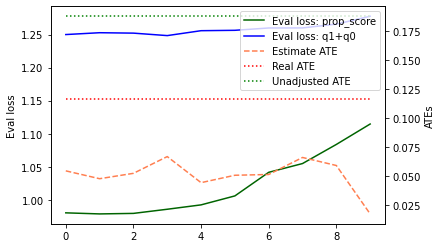

In [9]:
real = true_casual_effect(test_loader)
unadjust = (test_loader.dataset.response[test_loader.dataset.treatment == 1].mean() - test_loader.dataset.response[test_loader.dataset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)